# RNN for Text Classifications in NLP

source: https://www.geeksforgeeks.org/rnn-for-text-classifications-in-nlp/

In [2]:
!pip install tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 4.0 MB/s eta 0:00:0000:0100:01
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 984.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.0 MB/s eta 0:00:0000:0100:01
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 8.3 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21484 sha256=31bd7dc5e0d508d07e01c139df8729d570f9d2147f5de8d046ee16ae0de9b786
  Stored in directory: /Users/wel51x/Library/Caches/pi

### Imports

In [3]:
import tensorflow as tf 
import tensorflow_datasets as tfds 

import numpy as np 
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Load IMDB movies dataset

In [4]:
# Obtain the imdb review dataset from tensorflow datasets 
dataset = tfds.load('imdb_reviews', as_supervised=True)

2023-11-18 21:40:04.678627: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "INTERNAL: Couldn't parse JSON response from OAuth server.".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /Users/wel51x/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5WKHFP/imdb_reviews-train.…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /Users/wel51x/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5WKHFP/imdb_reviews-test.t…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /Users/wel51x/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5WKHFP/imdb_reviews-unsupe…

Dataset imdb_reviews downloaded and prepared to /Users/wel51x/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


### Separate test and train datasets 

In [5]:
train_dataset, test_dataset = dataset['train'], dataset['test'] 

### Split the test and train data into batches of 32 and shuffling the training set

In [6]:
batch_size = 32
train_dataset = train_dataset.shuffle(10000) 
train_dataset = train_dataset.batch(batch_size) 
test_dataset = test_dataset.batch(batch_size)

### Print a sample review and its label from the training set

In [7]:
example, label = next(iter(train_dataset)) 
print('Text:\n', example.numpy()[0]) 
print('\nLabel: ', label.numpy()[0])

Text:
 b"I stopped five minutes in when Beowulf was given a double-shot, automatic crossbow with sights on it. Not only do crossbows not have telescoping sights, but Beowulf beat Grendel in hand-to-hand combat. The terrible, wooden acting and eternal darkness that plagues all Sci-Fi Original Movies didn't help either. Having only gotten a few minutes in before I felt my bile rise and decided to watch I Love Lucy reruns instead, that's really about all I have to say. But, you might as well just realize that it's a made-for-TV movie and skip it right there.<br /><br />A travesty."

Label:  0


2023-11-18 21:44:04.492269: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Build Model

#### Text Vectorization

In [8]:
# Use the TextVectorization layer to normalize, split, and map strings to integers. 
encoder = tf.keras.layers.TextVectorization(max_tokens=10000) 
encoder.adapt(train_dataset.map(lambda text, _: text)) 

# Extract the vocabulary from the TextVectorization layer. 
vocabulary = np.array(encoder.get_vocabulary()) 

# Encode a test example and decoding it back. 
original_text = example.numpy()[0] 
encoded_text = encoder(original_text).numpy() 
decoded_text = ' '.join(vocabulary[encoded_text]) 

print('original: ', original_text) 
print('encoded: ', encoded_text) 
print('decoded: ', decoded_text)


original:  b"I stopped five minutes in when Beowulf was given a double-shot, automatic crossbow with sights on it. Not only do crossbows not have telescoping sights, but Beowulf beat Grendel in hand-to-hand combat. The terrible, wooden acting and eternal darkness that plagues all Sci-Fi Original Movies didn't help either. Having only gotten a few minutes in before I felt my bile rise and decided to watch I Love Lucy reruns instead, that's really about all I have to say. But, you might as well just realize that it's a made-for-TV movie and skip it right there.<br /><br />A travesty."
encoded:  [  10 2147  711  233    8   51 6513   14  335    4    1 8118    1   17
 7431   21    9   22   61   82    1   22   26    1 7431   19 6513 1558
 8983    8    1 4033    2  384 1596  112    3 5443 2569   12    1   32
  968  198   93  153  328  352  252   61 1772    4  164  233    8  156
   10  399   56    1 2209    3  831    6  104   10  116 3051 6041  297
  174   63   43   32   10   26    6  130   19

#### Create model

In [9]:
# Create model 
model = tf.keras.Sequential([ 
	encoder, 
	tf.keras.layers.Embedding( 
		len(encoder.get_vocabulary()), 64, mask_zero=True), 
	tf.keras.layers.Bidirectional( 
		tf.keras.layers.LSTM(64, return_sequences=True)), 
	tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
	tf.keras.layers.Dense(64, activation='relu'), 
	tf.keras.layers.Dense(1) 
]) 

# Model Summary 
model.summary() 

# Compile model 
model.compile( 
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
	optimizer=tf.keras.optimizers.Adam(), 
	metrics=['accuracy'] 
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

#### Fit model

In [10]:
# Train model and validate it on test set 
history = model.fit( 
	train_dataset, 
	epochs=5, 
	validation_data=test_dataset, 
)

Epoch 1/5
782/782 [==============================] - 373s 472ms/step - loss: 0.5011 - accuracy: 0.7304 - val_loss: 0.3777 - val_accuracy: 0.8508
Epoch 2/5
782/782 [==============================] - 381s 488ms/step - loss: 0.2736 - accuracy: 0.8863 - val_loss: 0.3061 - val_accuracy: 0.8681
Epoch 3/5
782/782 [==============================] - 387s 495ms/step - loss: 0.1931 - accuracy: 0.9220 - val_loss: 0.2987 - val_accuracy: 0.8718
Epoch 4/5
782/782 [==============================] - 383s 490ms/step - loss: 0.1406 - accuracy: 0.9463 - val_loss: 0.3402 - val_accuracy: 0.8716
Epoch 5/5
782/782 [==============================] - 395s 505ms/step - loss: 0.0947 - accuracy: 0.9656 - val_loss: 0.3929 - val_accuracy: 0.8543


#### Plot training & validation accuracy and loss plots.

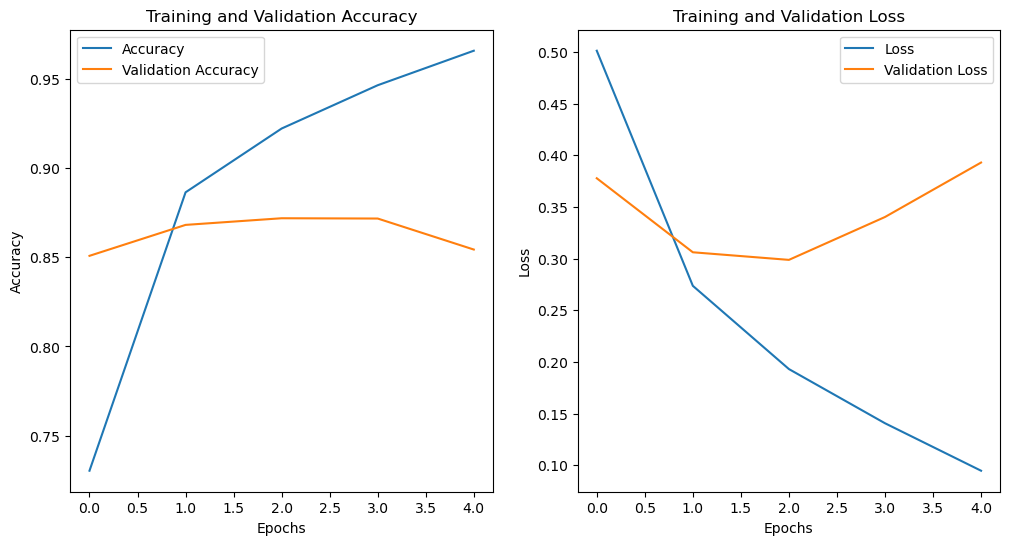

In [12]:
# Plotting the accuracy and loss over time 

# Training history 
history_dict = history.history 

# Seperating validation and training accuracy 
acc = history_dict['accuracy'] 
val_acc = history_dict['val_accuracy'] 

# Seperating validation and training loss 
loss = history_dict['loss'] 
val_loss = history_dict['val_loss'] 

# Plotting 
plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1) 
plt.plot(acc) 
plt.plot(val_acc) 
plt.title('Training and Validation Accuracy') 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend(['Accuracy', 'Validation Accuracy']) 

plt.subplot(1, 2, 2) 
plt.plot(loss) 
plt.plot(val_loss) 
plt.title('Training and Validation Loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend(['Loss', 'Validation Loss']) 

plt.show()